In [16]:
import numpy as np 
import pandas as pd
import os
import glob
import fnmatch
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ruptures as rpt


In [17]:
from lib.data_classes.pffpFolder import pffpDataFolder
from lib.signal_processing.signal_function import moving_average, find_deriv_change, find_drops
from lib.general_functions.global_constants import GRAVITY_CONST

In [18]:
# Testing the binary file classa
#TODO: for some reason I need the full path to read the files, I'll need to look into this in the future
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\test"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Potomac_to Jonathan"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/test_folder"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Clay_Air_Drops_GBE_AdamsPoint"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Mouth_1"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Clay_Air_Drops_GBE_AdamsPoint"
folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops"
calibration_dir = r"BlueDrop_Calibration_Factors.xlsx"

In [19]:
# TODO: Combine the pffp_id and the read_calibration_excel_sheet just have the objet call inside

test_folder = pffpDataFolder(folder_dir, pffp_id = 9, calibration_factor_dir=calibration_dir)
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops 
Date range: Not set 
PFFP id: 9                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: Not set                 
Num files with drops: Not Set


In [20]:
# Read the calibration data
test_folder.read_calibration_excel_sheet()
test_folder.calibration_excel_sheet

# Select the specific calibration params
# test_folder.get_sensor_calibration_params("Sequim_2021")

# test_folder.get_sensor_calibration_params("March_2023")
test_folder.get_sensor_calibration_params("October_2023")

# Init a pffpFile instances for each binary file and store the results in the folder
test_folder.store_pffp_files(recursive = False)

print(test_folder) # Information about the folder

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops 
Date range: Not set 
PFFP id: 9                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 3                 
Num files with drops: Not Set


In [21]:
# Analyze the selected pffp files
test_folder.analyze_all_files(store_df=False, use_pore_pressure=True, select_accel=["2g_accel", "18g_accel", "200g_accel"])


Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\no_drop_folder' already exists.
Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\funky' already exists.

Progress finding files with drops...
[==================================================] 100.00% ETA (min): 0.03
Initial analysis complete!


In [22]:
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops 
Date range: Not set 
PFFP id: 9                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 3                 
Num files with drops: 3



Progress processing drops in files...
end index 36
0.954331908553011


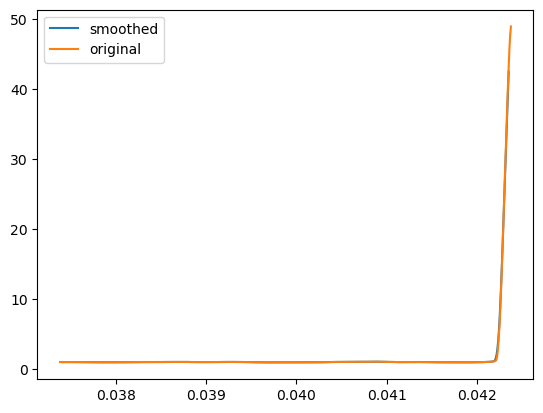

start accel value 1.2563680375319506

Point meeting criteria not found
Criteria not met: peak before impulse (release point)
drop id: 1 in bLog0C21.bin
Moving file to funky folder
end index 42
0.9560444243192243


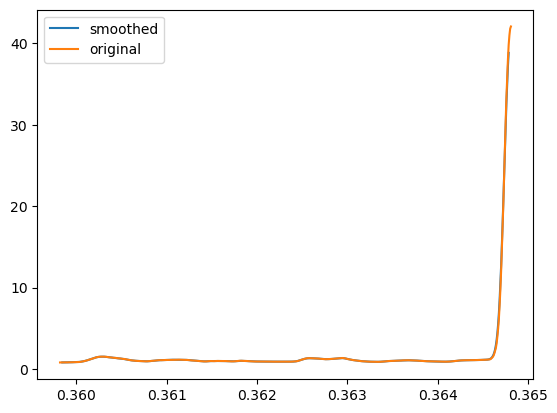

start accel value 1.9259387603959206
end index 49
0.9419901118048355


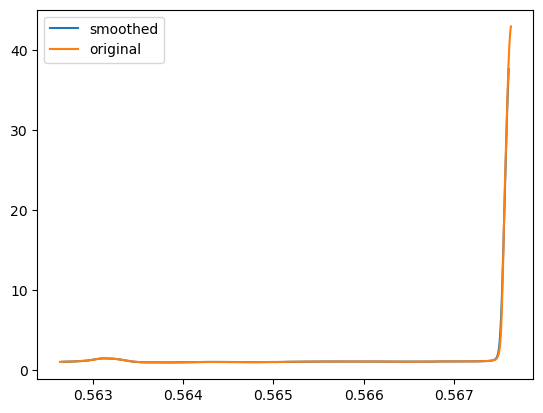

start accel value 1.581567710106315
[================----------------------------------] 33.33% ETA (min): 0.029end index 85
0.9879144349644929


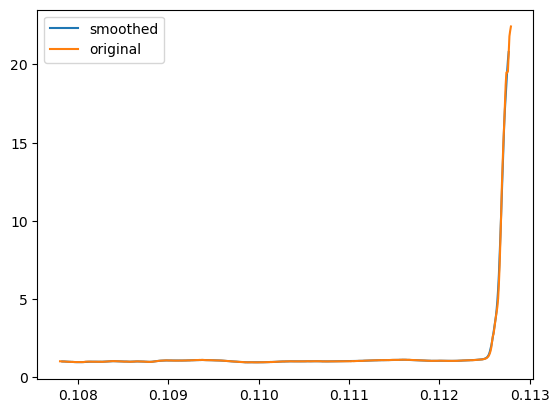

start accel value 1.6986421501416147
end index 82
0.9392716083210189


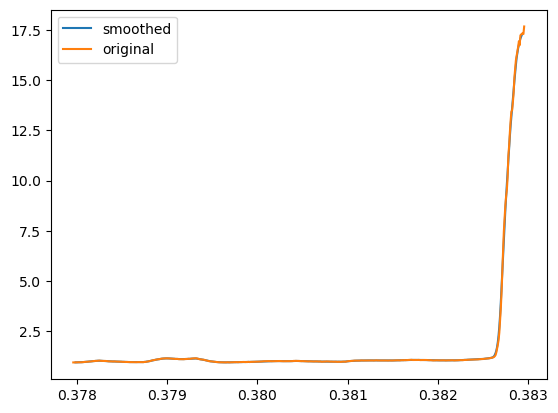

start accel value 1.4483149213804614
[=================================-----------------] 66.67% ETA (min): 0.0054end index 18
0.10978000844144217


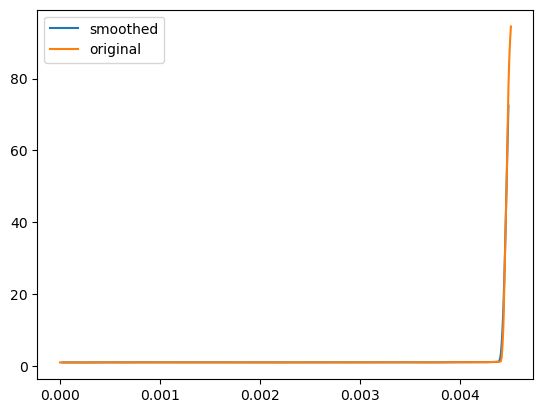

start accel value 1.1260846343123965

Point meeting criteria not found
Criteria not met: peak before impulse (release point)
drop id: 1 in bLog0C33.bin
Moving file to funky folder
end index 8
0.06426521328907316


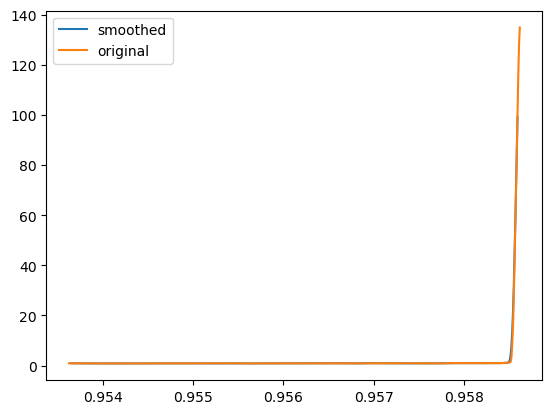

start accel value 1.2921476263609122
[==================================================] 100.00% ETA (min): 1.7e-08

In [23]:
test_folder.process_drop_files()

In [65]:
index = 0
if  not True:
    file =test_folder.pffp_drop_files[index]
else:
    file=test_folder.pffp_funky_files[index]
 
print(file)


File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\funky\bLog0C21.bin 
Num Drops in file: 3         
Drop Date: 2024-04-24 
Drop Time: 20:00:54.970967         
df stored: False        
Concat accel stored True


In [66]:
print(file)

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops\funky\bLog0C21.bin 
Num Drops in file: 3         
Drop Date: 2024-04-24 
Drop Time: 20:00:54.970967         
df stored: False        
Concat accel stored True


In [67]:
index = 1
drop = file.drops[index]
print(drop)
# file.drops[index].quick_view_release(interactive = False)
# file.drops[index].quick_view_impulse(interactive = False)
# display(drop.release_df)

----- Drop Info ----- 
Containing file: bLog0C21.bin 
File Drop Index: 2 
Water Drop: None            
Drop indices: {'release_index': 39495, 'start_impulse_index': 43755, 'end_impulse_index': 43820}


In [68]:
start = drop.drop_indices["start_impulse_index"]-5
end = drop.drop_indices["end_impulse_index"]

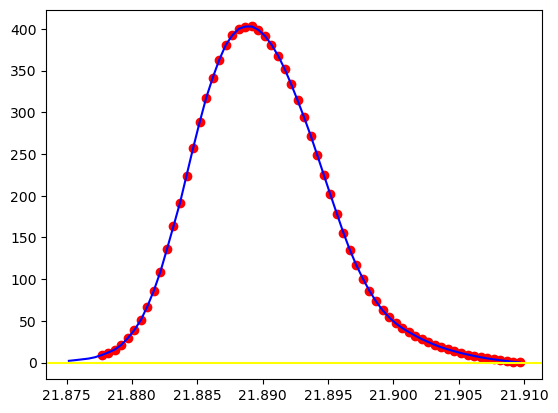

In [69]:

plt.plot(drop.release_df["Time"].loc[start:end], drop.release_df["accel"].loc[start:end], color = "blue")
plt.scatter(drop.impulse_df["Time"], drop.impulse_df["accel"], color = "red")
# plt.xlim([34.045, 34.050])
# plt.axhline(0.95 * GRAVITY_CONST)
plt.axhline(0 * GRAVITY_CONST, color = "yellow")
# plt.plot(file.whole_df["Time"], file.concat_accel)

----- Drop Info ----- 
Containing file: bLog0C21.bin 
File Drop Index: 1 
Water Drop: None            
Drop indices: None not finished being processed


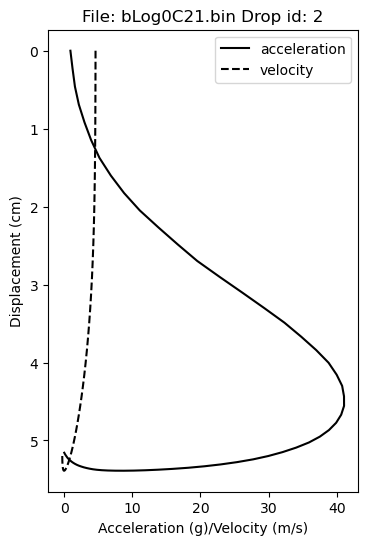

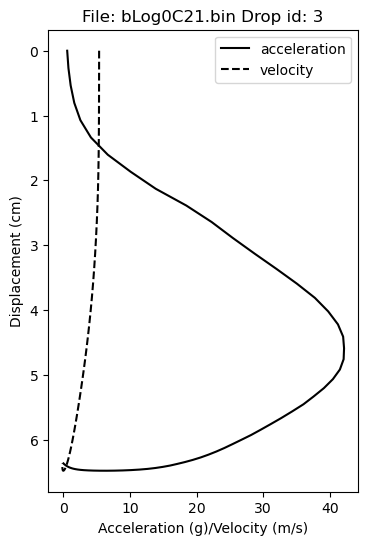

In [70]:
# This plot will be on 1g lower than the value from the sensor
file.plot_drop_impulses(hold=False, legend = True)